## Project 2 : Predicting Boston Housing Prices

The dataset for this project originates from the 
UCI Machine Learning Repository. The Boston housing data was 
collected in 1978 and each of the 506 
entries represent aggregated data about 14 features for homes from 
various suburbs in Boston, Massachusetts. For the purposes of this 
project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points 
likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be 
considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are 
essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account
 for 35 years of market inflation.

In [94]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes._axes as axes
sns.set()

# sklearn specific imports
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score, make_scorer

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
data.rename(lambda name:name.lower(), axis=1, inplace=True)
prices = data['medv']
features = data.drop('medv', axis = 1)
    
# Success
print(f"Boston housing dataset has {data.shape[0]} data points with "
      f"{data.shape[1]} variables each.")

Boston housing dataset has 489 data points with 4 variables each.


In [95]:
# lets take a look at the dataset
data.head(3)

,rm,lstat,ptratio,medv
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0


### Phase 1 - Data Exploration
Since the main goal of this project is to construct a working model 
which has the capability of predicting the value of houses, we will 
need to separate the dataset into **features** and the **target 
variable**. The **features**, `'rm'`, `'lstat'`, and `'ptratio'`, 
give us quantitative information about each data point. The **target
variable**, `'medv'`, will be the variable we seek to predict. 
These are stored in `features` and `prices`, respectively.

In [96]:
# TODO: Minimum price of the data
minimum_price = data.medv.min()

# TODO: Maximum price of the data
maximum_price = data.medv.max()

# TODO: Mean price of the data
mean_price = data.medv.mean()

# TODO: Median price of the data
median_price = data.medv.median()

# TODO: Standard deviation of prices of the data
std_price = data.medv.std()

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print(f"Minimum price: ${minimum_price:0.2f}") 
print(f"Maximum price: ${maximum_price:0.2f}")
print(f"Mean price: ${mean_price:0.2f}")
print(f"Median price ${median_price:0.2f}")
print(f"Standard deviation of prices: ${std_price:0.2f}")

Statistics for Boston housing dataset:

Minimum price: $105000.00
Maximum price: $1024800.00
Mean price: $454342.94
Median price $438900.00
Standard deviation of prices: $165340.28


### Phase 2 - Feature Observation
As a reminder, we are using three features from the Boston housing 
dataset: `'rm'`, `'lstat'`, and `'ptratio'`. For each data point :
- `'rm'` is the average number of rooms among homes in the neighborhood.
- `'lstat'` is the percentage of homeowners in the neighborhood considered 
"lower class" (working poor).
- `'ptratio'` is the ratio of students to teachers in primary and 
secondary schools in the neighborhood.

 =========================================
* Would you expect a home that has an `'rm'` value(number of rooms) of 
6 be worth more or less than a home that has an `'rm'` value of 7?

   -> Homes with higher number of rooms, cover larger areas and hence 
   ought to be more expensive.

* Would you expect a neighborhood that has an `'lstat'` value(percent 
of lower class workers) of 15 have home prices be worth more or less 
than a neighborhood that has an `'lstat'` value of 20?

   -> Neighborhoods wherein there are higher percentages of low 
   class workers are expected to have lower home prices. Hence a 
   negative correlation is expected.
    
* Would you expect a neighborhood that has an `'ptratio'` value(ratio 
of students to teachers) of 10 have home prices be worth more or less 
than a neighborhood that has an `'ptratio'` value of 15?

   -> Neighborhoods which have schools with higher students to 
   teachers ratio are usually the ones with lower resources and 
   hence are more populated with less income families. 
   Consequently, home prices are expected to be lower in those 
   neighborhoods.
   
To test whether these conjectures are true or not, we can plot the 
trends of the target (medv) against rm, lstat and ptratio as 
follows:

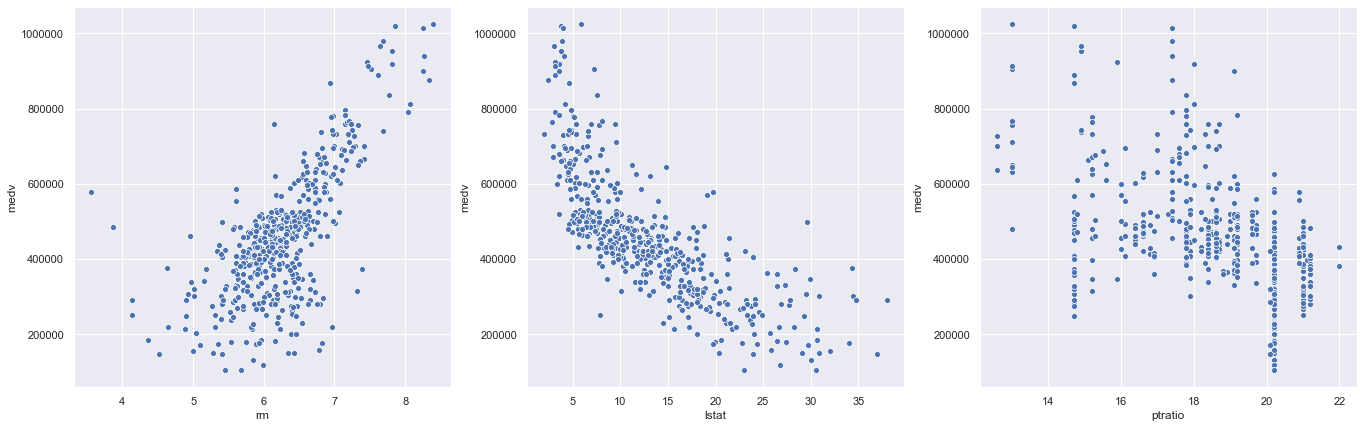

In [97]:
f, ax = plt.subplots(1, 3, figsize=(23,7))
sns.scatterplot(data=data, x='rm', y='medv', ax=ax[0]);
sns.scatterplot(data=data, x='lstat', y='medv', ax=ax[1]);
sns.scatterplot(data=data, x='ptratio', y='medv', ax=ax[2]);   

From the scatterplots, its is evident that `medv` increases as `rm` 
increases while it decreases as `lstat` increases. The correlation 
with `ptratio` is somewhat less pronounced, however, there still 
seems to be an overall decreasing trend with increase in `ptratio`.

### Phase 3 - Developing a Model
In this section of the project, we will develop the tools and 
techniques necessary for a model to make a prediction. Being able to 
make accurate evaluations of each model's performance through the use 
of these tools and techniques helps to greatly reinforce the confidence 
in the predictions.

#### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without 
quantifying its performance over training and testing. This is 
typically done using some type of performance metric, whether it is 
through calculating some type of error, the goodness of fit, or some 
other useful measurement. For this project, we will be calculating 
the 
[*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), 
R<sup>2</sup>, to quantify a model's performance. The coefficient 
of determination for a model is a useful statistic in regression 
analysis, as it often describes how "good" that model is at making 
predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the 
percentage of squared correlation between the predicted and actual 
values of the **target variable**. A model with an R<sup>2</sup> of 
0 is no better than a model that always predicts the *mean* of the 
target variable, whereas a model with an R<sup>2</sup> of 1 perfectly 
predicts the target variable. Any value between 0 and 1 indicates what 
percentage of the target variable, using this model, can be explained 
by the **features**. _A model can be given a negative R<sup>2</sup> as 
well, which indicates that the model is **arbitrarily worse** than one 
that always predicts the mean of the target variable._

* R2 score of 0 means that the dependent variable cannot be predicted
 from the independent variable.
* R2 score of 1 means the dependent variable can be predicted from the
 independent variable.
* R2 score between 0 and 1 indicates the extent to which the dependent
 variable is predictable. An 
* R2 score of 0.40 means that 40 percent of the variance in Y is
 predictable from X.

In [98]:
# this function returns r2 score 
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    return r2_score(y_true, y_predict)

### Phase 4 - Implementation: Shuffle and Split Data
- Use `train_test_split` from `sklearn.model_selection` to shuffle and 
split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to a value of your 
    choice. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`
  , and `y_test`.

In [99]:
xtrain, xtest, ytrain,y_test = train_test_split(features, prices)
print("Training and testing split was successful.")

Training and testing split was successful.



### Phase 5 - Analyzing Model Performance Using Learning Curves

#### Learning Curves
The following code cell produces four graphs for a decision tree model 
with different maximum depths. Each graph visualizes the learning curves 
of the model for both training and testing as the size of the training 
set is increased. Note that the shaded region of a learning curve denotes 
the uncertainty of that curve (measured as the standard deviation). 
The model is scored on both the training and testing sets using R<sup>2</sup>, 
the coefficient of determination.  

In [100]:
# Produce learning curves for varying training set and maximum 
# depths. this function will help plot learning curves.
def plot_learning_curve(estimator, title, ax, X, y, ylim=None, 
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes, scoring='r2')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
          label="Cross-validation score")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    ax.legend(loc='best')
    ax.set_ylim(*ylim)
    ax.set_title(title)
    ax.set_xlabel("Training Points")
    ax.set_ylabel("Score")

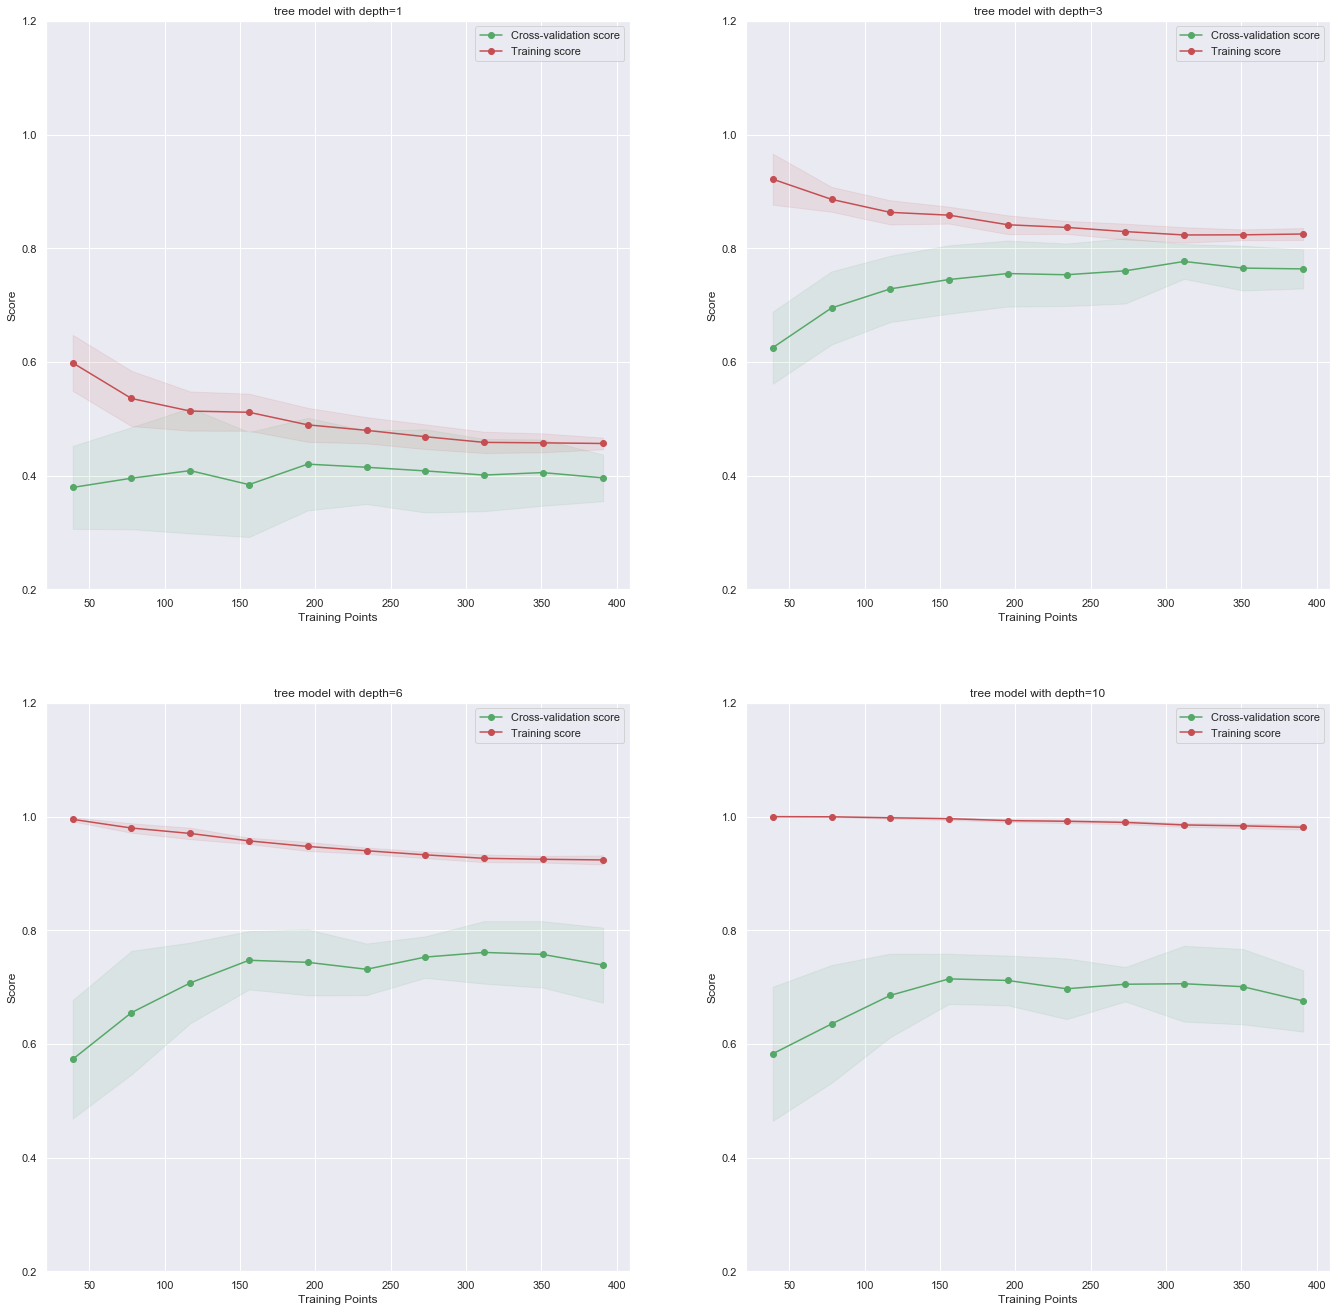

In [101]:
# now lets plot learning curves for different decision tree depths
tree_depths = [1, 3, 6, 10]

def return_depth():
    for depth in tree_depths:
        yield depth
                
gen_func = return_depth()    
f, ax = plt.subplots(2, 2, figsize=(23, 23)) #type: _, axes.Axes

for row in range((len(ax) // 2) + 1):
    for col in range((len(ax) // 2 + 1)):
        depth = next(gen_func)
        dtregressor = DecisionTreeRegressor(max_depth=depth) 
        plot_learning_curve(dtregressor, 
                            f'tree model with depth={depth}',
                            ax[row, col],
                            features,
                            prices,
                            (0.2, 1.2))

The decision tree model with a depth=3 is the best performing model
with the highest training and cross validation scores. Any depth 
higher than that overfits on the training data and anything lower 
underfits on the training data, yielding lower scores in both of 
these corner cases.

### Phase 6 - Implementation: Fitting a Model

In [102]:
# this function takes an estimator, optimises it usingGridSearch 
# and then returns the best estimator model that can later be used 
# to predict target variable
def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = X.shape[0], test_size = 0.20, 
                           random_state = 0)

    # TODO: Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': range(1,11)}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(r2_score)

    # TODO: Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, param_grid=params, 
                        scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

#### Making Predictions
Once a model has been trained on a given set of data, it can now be 
used to make predictions on new sets of input data. In the case of a 
*decision tree regressor*, the model has learned *what the best 
questions to ask about the input data are*, and can respond with a 
prediction for the **target variable**. 

### Phase 7 - Optimal Model

In [103]:
# Fit the training data to the model using grid search
reg = fit_model(xtrain, ytrain)

In [104]:
# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model."
      .format(reg.get_params()['max_depth']))

print("\nFor the Optimal model: ")
train_predicts = reg.predict(xtrain)
test_predicts = reg.predict(xtest)

print(f"train accuracy: {r2_score(ytrain, train_predicts):0.2f}")
print(f"test accuracy: {r2_score(y_test, test_predicts):0.2f}")

Parameter 'max_depth' is 4 for the optimal model.

For the Optimal model: 
train accuracy: 0.88
test accuracy: 0.77


### Phase 8 - Predicting Selling Prices
Let us try to predict the housing prices of the following clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

In [105]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $411,915.00
Predicted selling price for Client 2's home: $236,124.00
Predicted selling price for Client 3's home: $876,400.00



<p><b>For Client 3:</b> I would recommend client 3 to sell the home at $876,400.00. This is the highest price for a house among all the clients and this is in agreement with the fact that client 3 has a house with the highest number of rooms and has the lowest neighborhood poverty level and student - teacher ratio of nearby schools. Additionally, the above price does not exceed the maximum price of houses from among the data set on which the model was trained and hence the value predicted by the model should be accurate enough. </p>

<p><b>For Client 2:</b> Client 2 has significant neighborhood poverty level, student-teacher ratio of nearby schools and has the smallest house. The values of the features are close to the maximum (for poverty level and student-teacher ratio) and minimum(for room number). As a result, it is expected that the selling price of the house  for client 2 would thus be the lowest and should be much less than the mean value of house prices from the dataset. This is in accordance to the selling price value predicted by the model. I would thus suggest client 2 to sell his/her house at $236,124.00. This value, as expected, is lower than the mean value of houses from the data set (around 1 standard deviation away from the mean) and is higher than the minimum price of houses as depicted in the dataset.</p>

<p><b>For Client 1:</b>Client 1 has slightly higher values than average for the neighborhood poverty levels and relatively lower value than average for the number of rooms in his/her house when compared to the dataset. It is thus expected that, the selling price of the house for client 1 should be less than but in close vicinity to the mean value of houses in the dataset. The value predicted by the model is in exact accordance to the aforementioned criteria and hence I would suggest client 1 to sell his/her house at $411,915.00</p>

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model 
is either too complex or too simple to sufficiently generalize to new 
data. Sometimes, a model could use a learning algorithm that is not 
appropriate for the structure of the data given. Other times, the data 
itself could be too noisy or contain too few samples to allow a model to 
adequately capture the target variable — i.e., the model is underfitted. 

In [106]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $411,417.39
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $402,531.82
Trial 10: $413,700.00

Range in prices: $29,438.89


### Phase 9 - Applicability
The housing prices data from 1978 bear very little relevance in today's context of 2018. Inflation is supposed to greatly ramp up the prices within the area and trying to predict current day housing prices based on data that is 40 years old will be prone to exaggerated modelling assumptions. Additionally, 40 years is enough time for the demography and social structure of a place to change drastically and hence the features used to train the model would consequently be irrelevant.

I do not think the features present in the data are sufficient to describe a home. The features rely too much on indirect factors without taking into consideration the effect of more direct factors like household income level, age of the house, square feet of the plot area, vicinity of the house to transportation routes or civil amenities like shopping malls or offices and so on.

I would say, the model is not robust enough. The predictions on the house prices for a particular client vary over a wide range. This puts the risk of either over or under pricing the house by wide margins which is clearly too big of a room for error to be accepted by contemporary standards.

The features used to train the model (RM, LSTAT, PTRATIO) would vary widely over rural and urban areas and even between different urban cities or states. Therefore, the data collected and consequently a model trained on such data in an urban area like Boston would not be applicable in a rural city.

No, it is not fair to judge the price of an individual home based on the characteristics of the entire neighborhood. As has been mentioned previously, the decision tree model that has been created in this project was modelled based on features that were indirectly related to the price of an individual home. The features did not take into account, the effect of more direct features like household income level, plot area, available amenities and so on and hence puts the model at the risk of being oversimplified.

Therefore, to make the model more relevant and applicable to real world settings, the data set the model is based on needs to be updated, more data should be provided on which the model can train on and eventually to make the model more robust and less variant, more direct and relevant features should be included in the dataset .
